In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
!pip install timm torchsummary tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 385, in run
    conflicts = self

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Code to edit the csv with correct image_file paths

In [ ]:
orig_image_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training'
brdr_image_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/std_shape/data_border_reflect_101/1.training'

In [ ]:
# creating a 2d list where the first list contains path of images
# the second list contains a flag denoting whether the image is from original set or bordered
# and the third list contains one-hot encoded label vectors
image_path_list = []

In [ ]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    
    if i[-13:-4] not in exc_list:
      # adding the image path, and the label
      image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])
    else:
      continue

In [ ]:
# loading image paths from original dataset
img_list(orig_image_path)

# loading image paths from pre-processed dataset
img_list(brdr_image_path)

In [ ]:
len(image_path_list)

9386

In [ ]:
train_list, test_list = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8)

In [ ]:
len(test_list)

1878

## Creating the dataset class

In [ ]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

1878
0 (197, 167, 3) (1, 3)
1 (224, 224, 3) (1, 3)
2 (234, 155, 3) (1, 3)
3 (175, 232, 3) (1, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


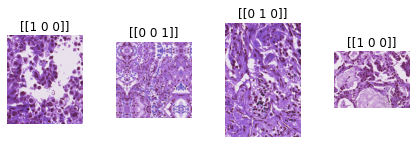

In [ ]:
# check if the dataloader works
check_loader = LUAD(image_list=test_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

In [ ]:
type(check_loader[1][0])

numpy.ndarray

In [ ]:
# creatin the train dataset
train_dataset = LUAD(train_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),]
                                                     ))

# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),]
                                                    ))

In [ ]:
batch_size = 32

In [ ]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 0,
                              )

# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 0,
                             )

In [ ]:
model_vit_base_patch32_224 = timm.create_model('vit_base_patch32_224', pretrained = True, num_classes = 3)
#print(model(torch.randn(1, 3, 224, 224)))

In [ ]:
torchsummary.summary(model_vit_base_patch32_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 7, 7]       2,360,064
          Identity-2              [-1, 49, 768]               0
        PatchEmbed-3              [-1, 49, 768]               0
           Dropout-4              [-1, 50, 768]               0
         LayerNorm-5              [-1, 50, 768]           1,536
            Linear-6             [-1, 50, 2304]       1,771,776
           Dropout-7           [-1, 12, 50, 50]               0
            Linear-8              [-1, 50, 768]         590,592
           Dropout-9              [-1, 50, 768]               0
        Attention-10              [-1, 50, 768]               0
         Identity-11              [-1, 50, 768]               0
        LayerNorm-12              [-1, 50, 768]           1,536
           Linear-13             [-1, 50, 3072]       2,362,368
             GELU-14             [-1, 5

In [ ]:
y_pred = model_vit_base_patch32_224(torch.randn(1, 3, 224, 224))

In [ ]:
y_pred[0]

tensor([-0.6435,  1.3121, -1.0052], grad_fn=<SelectBackward0>)

In [ ]:
y_pred.shape

torch.Size([1, 3])

In [ ]:
type(y_pred)

torch.Tensor

In [ ]:
y_pred.argmax(axis=1)

tensor([1])

In [ ]:
y = np.array([[0, 1, 0]])

In [ ]:
torch.from_numpy(y)

tensor([[0, 1, 0]])

In [ ]:
y.shape

(1, 3)

In [ ]:
nn.CrossEntropyLoss()(y_pred, torch.from_numpy(y.argmax(axis=1)))

tensor(0.2151, grad_fn=<NllLossBackward0>)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  
  for batch, (x, y) in enumerate(data_loader):
    
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)

    #clear gradients
    opt.zero_grad()

    # forward pass
    y_pred = model(x)

    # calculate loss
    loss = loss_fn(y_pred, y.argmax(axis=1))
    train_loss += loss
    train_acc += eval_fn(y.argmax(axis=1), y_pred.detach().numpy().argmax(axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= (len(data_loader)/batch_size)
  train_acc /= (len(data_loader)/batch_size)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      test_pred = model(X)
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, torch.from_numpy(y.argmax(axis=1)))
      test_acc += eval_fn(y.argmax(axis=1), test_pred.detach().numpy().argmax(axis=1))
      
      # Adjust metrics and print out
      test_loss /= (len(data_loader)/batch_size)
      test_acc /= (len(data_loader)/batch_size)
      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
      return test_loss, test_acc

In [ ]:
model_save_path = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224.pth'

In [ ]:
epochs = 20

In [ ]:
valid_acc = -np.inf

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader,
             model=model_vit_base_patch32_224,
             loss_fn=nn.CrossEntropyLoss(),
             opt=Adam(model_vit_base_patch32_224.parameters(), lr=0.001),
             eval_fn=accuracy_score
             )
  
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch32_224,
                                  loss_fn=nn.CrossEntropyLoss,
                                  eva_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch32_224.state_dict(),
               f = model_save_path)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------


RuntimeError: ignored